#Exploring Defensive Distillation 

Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.utils import shuffle

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

TensorFlow 1.x selected.


#Implementing Defensive Distillation 

The implementation divide to two components:


*   First we build an activation layer with Temperature component.
*   Second we train teacher and a student networks with the spacial training setups.


  

In [0]:
def temperature_softmax(x):
  return tf.nn.softmax(tf.math.divide(x, Temperature))

def build_mnist_distilled_models(num_classes):
    # build two identical architectures with spacial temperature softmax
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    # teacher
    teacher = keras.Sequential()
    teacher.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    teacher.add(layers.Conv2D(8, (3, 3), activation=activation))
    teacher.add(layers.MaxPooling2D(pool_size=(2, 2)))
    teacher.add(layers.Dropout(0.25))
    teacher.add(layers.Flatten())
    teacher.add(layers.Dense(128, activation=activation))
    teacher.add(layers.Dropout(0.5))
    teacher.add(layers.Dense(num_classes))
    teacher.add(layers.Activation('softmax', name='y_pred'))
    # student
    student = keras.Sequential()
    student.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    student.add(layers.Conv2D(8, (3, 3), activation=activation))
    student.add(layers.MaxPooling2D(pool_size=(2, 2)))
    student.add(layers.Dropout(0.25))
    student.add(layers.Flatten())
    student.add(layers.Dense(128, activation=activation))
    student.add(layers.Dropout(0.5))
    student.add(layers.Dense(num_classes))
    student.add(layers.Activation('softmax', name='y_pred'))


              
    return teacher, student

In [0]:
def trainAndTransferKnowladge(train_images,train_labels,test_images,test_labels, Temperature, num_classes):
  
  batch_size = 128
  maxepoches = 12


  sess = tf.Session()
  keras.backend.set_session(sess)
  
  
  teacher = build_mnist_model(num_classes)
  temp_soft_teacher = layers.Activation(temperature_softmax, name='temperature_softmax')(teacher.layers[-2].output)
  trainTeacher = keras.Model(teacher.input, temp_soft_teacher)

  # phase 1 : train the teacher with one hot labels
  trainTeacher.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
  print('train teacher:')
  teacherHist = trainTeacher.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels))

  # phase 2 : train the student with the soft labels
  student = build_mnist_model(num_classes)
  temp_soft_student = layers.Activation(temperature_softmax, name='temperature_softmax')(student.layers[-2].output)
  trainStudent = keras.Model(student.input, temp_soft_student)
  
  train_soft_labels = trainTeacher.predict(train_images)
  
  student.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
  trainStudent.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
  print('train student:')
  studentHist = trainStudent.fit(train_images, train_soft_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels))
  return teacher, student
  

#Attacks:


*   FGSM
*   TGSM
*PGD (targeted & non-targeted)



--- Fast Gradient Sign Method (FGSM) ---

In [0]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [0]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FastGradientSignMethod(model, images, labels, epsilon=0.3):
    true_label_tensor = keras.backend.placeholder(shape=(None, num_classes))
    adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, model.output)
    get_grads = keras.backend.function([model.input, true_label_tensor], keras.backend.gradients(adv_loss, model.input))
    
    adv_grads = get_grads([images, labels])[0]
    
    adv_out = images + epsilon * np.sign(adv_grads)
    return adv_out

--- Targeted Gradient Sign Method (TGSM) ---

In [0]:
''' Targeted Gradient Sign Method implementation - A targeted variant of the FGSM attack
    here we minimize the loss with respect to the target class, as opposed to maximizing the loss with respect
    to the source class
'''
def TargetedGradientSignMethod(model, images, target, epsilon=0.3):
    true_label_tensor = keras.backend.placeholder(shape=(None, num_classes))
    adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, model.output)
    get_grads = keras.backend.function([model.input, true_label_tensor], keras.backend.gradients(adv_loss, model.input))
    
    adv_grads = get_grads([images, target])[0]
    
    adv_out = images - epsilon * np.sign(adv_grads)
    return adv_out

--- Basic Iterative Method (BIM) ---

In [0]:
def BasicIterativeMethod(model, images, labels, epsilon=0.1, iter_eps = 0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False):
    
    adv_out = images
    
    for iteration in range(iterations):
        print('Iteration:', iteration)
        # Perturb the input
        if targeted:
            adv_out = TargetedGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
        else:
            adv_out = FastGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
            
        # Project the perturbation to the epsilon ball
        perturbation = adv_out - images
        norm = np.sum(np.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = np.sqrt(np.maximum(10e-12, norm))
        factor = np.minimum(1, np.divide(epsilon, norm))
        adv_out = np.clip(images + perturbation * factor, 0.0, 1.0)
    
    return adv_out

#Create and Train a Simple MNIST CNN Classifier then attack it 

In [0]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model(num_classes):
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [0]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [10]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
# Train the model
batch_size = 128
maxepoches = 12

model = build_mnist_model(num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 34s 566us/sample - loss: 0.4248 - categorical_accuracy: 0.8720 - val_loss: 0.0971 - val_categorical_accuracy: 0.9704
Epoch 2/12
60000/60000 [==============================] - 34s 559us/sample - loss: 0.1461 - categorical_accuracy: 0.9566 - val_loss: 0.0630 - val_categorical_accuracy: 0.9805
Epoch 3/12
60000/60000 [==============================] - 33s 558us/sample - loss: 0.1101 - categorical_accuracy: 0.9667 - val_loss: 0.0472 - val_categorical_accuracy: 0.9843
Epoch 4/12
60000/60000 [==============================] - 34s 562us/sample - loss: 0.0932 - categorical_accuracy: 0.9718 - val_loss: 0.0454 - val_categorical_accuracy: 0.9848
Epoch 5/12
60000/60000 [==============================] - 33s 553us/sample - loss: 0.0815 - categorical_accuracy: 0.9755 - val_loss: 0.0407 - val_categorical_accuracy: 0

Test loss: 3.95
Successfully moved out of source class: 0.77
Mean perturbation distance: 0.23


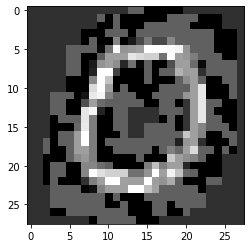

In [12]:
adv_images = FastGradientSignMethod(model, test_images, test_labels, epsilon=0.3)
TestAttack(model, adv_images, test_images, test_labels, targeted=False)

Test loss: 3.33
Successfully moved out of source class: 0.77
Test loss: 2.49
Successfully perturbed to target class: 0.34
Mean perturbation distance: 0.23


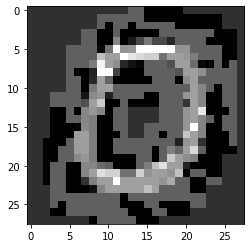

In [13]:
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
adv_images = TargetedGradientSignMethod(model, test_images, target, epsilon=0.3)
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 17.19
Successfully moved out of source class: 1.00
Mean perturbation distance: 0.14


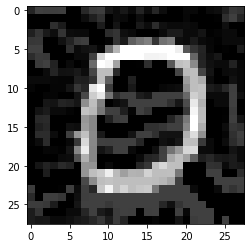

In [14]:
adv_images = BasicIterativeMethod(model, test_images, test_labels, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=False)
TestAttack(model, adv_images, test_images, test_labels, target, targeted=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 11.15
Successfully moved out of source class: 1.00
Test loss: 0.02
Successfully perturbed to target class: 1.00
Mean perturbation distance: 0.14


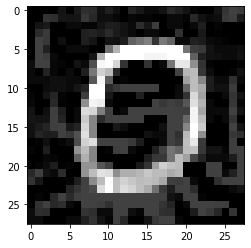

In [15]:
adv_images = BasicIterativeMethod(model, test_images, target, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=True)
TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)

#Train a Simple MNIST CNN Classifier with Defensive Distillation then attack it 

In [0]:
# train with distilation
Temperature = 30
teacher, student = trainAndTransferKnowladge(train_images,train_labels,test_images,test_labels, Temperature = Temperature, num_classes)

train teacher:
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 33s 550us/sample - loss: 0.6923 - categorical_accuracy: 0.7987 - val_loss: 0.2408 - val_categorical_accuracy: 0.9301
Epoch 2/12
60000/60000 [==============================] - 32s 540us/sample - loss: 0.3189 - categorical_accuracy: 0.9044 - val_loss: 0.1783 - val_categorical_accuracy: 0.9468
Epoch 3/12
60000/60000 [==============================] - 33s 543us/sample - loss: 0.2653 - categorical_accuracy: 0.9207 - val_loss: 0.1424 - val_categorical_accuracy: 0.9571
Epoch 4/12
60000/60000 [==============================] - 32s 539us/sample - loss: 0.2324 - categorical_accuracy: 0.9290 - val_loss: 0.1226 - val_categorical_accuracy: 0.9619
Epoch 5/12
60000/60000 [==============================] - 33s 543us/sample - loss: 0.2168 - categorical_accuracy: 0.9333 - val_loss: 0.1110 - val_categorical_accuracy: 0.9666
Epoch 6/12
60000/60000 [==============================] - 32

In [0]:
student.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

Test loss: 14.22
Successfully moved out of source class: 0.09
Mean perturbation distance: 0.02


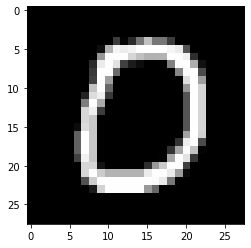

In [0]:
adv_images = FastGradientSignMethod(student, test_images, test_labels, epsilon=0.3)
TestAttack(student, adv_images, test_images, test_labels, targeted=False)

Test loss: 30.96
Successfully moved out of source class: 0.53
Test loss: 45.98
Successfully perturbed to target class: 0.28
Mean perturbation distance: 0.23


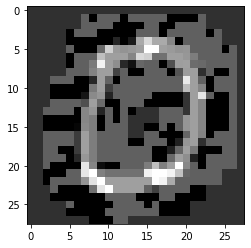

In [0]:
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
adv_images = TargetedGradientSignMethod(student, test_images, target, epsilon=0.3)
TestAttack(student, adv_images, test_images, test_labels, target, targeted=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 33.73
Successfully moved out of source class: 0.09
Mean perturbation distance: 0.01


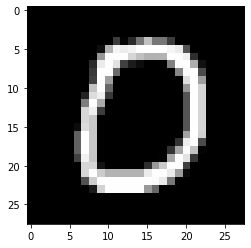

In [0]:
adv_images = BasicIterativeMethod(student, test_images, test_labels, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=False)
TestAttack(student, adv_images, test_images, test_labels, target, targeted=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 41.42
Successfully moved out of source class: 0.81
Test loss: 10.80
Successfully perturbed to target class: 0.76
Mean perturbation distance: 0.14


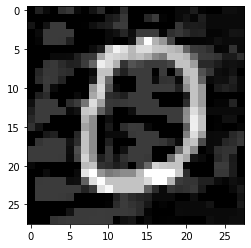

In [0]:
adv_images = BasicIterativeMethod(student, test_images, target, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=True)
TestAttack(student, adv_images, test_images, test_labels, target, targeted=True)


#Exploring Binary classification case

In [0]:
# setup for the dataset
class1 = np.random.randint(0,10)
class2 = (class1 + np.random.randint(1,10)) % 10

class1_train = train_images[np.where(train_labels[:,class1]==1)]
class1_train_labels = train_labels[np.where(train_labels[:,class1]==1)]
class2_train = train_images[np.where(train_labels[:,class2]==1)]
class2_train_labels = train_labels[np.where(train_labels[:,class2]==1)]

binary_train = np.concatenate([class1_train, class2_train], axis=0)
binary_train_labels = np.concatenate([class1_train_labels, class2_train_labels],axis=0)

class1_test = test_images[np.where(test_labels[:,class1]==1)]
class1_test_labels = test_labels[np.where(test_labels[:,class1]==1)]
class2_test = test_images[np.where(test_labels[:,class2]==1)]
class2_test_labels = test_labels[np.where(test_labels[:,class2]==1)]

binary_test = np.concatenate([class1_test, class2_test], axis = 0)
binary_test_labels = np.concatenate([class1_test_labels, class2_test_labels], axis = 0)


In [0]:
# change the labels to 2 classes:
num_classes = 2

binary_train_labels = np.argmax(binary_train_labels, axis=-1)
binary_test_labels = np.argmax(binary_test_labels, axis=-1)

for i in range(binary_train_labels.shape[0]):
  if binary_train_labels[i] == class1:
    binary_train_labels[i] = 0
  else: binary_train_labels[i] = 1

for i in range(binary_test_labels.shape[0]):
  if binary_test_labels[i] == class1:
    binary_test_labels[i] = 0
  else: binary_test_labels[i] = 1


binary_train_labels = keras.utils.to_categorical(binary_train_labels, num_classes)
binary_test_labels = keras.utils.to_categorical(binary_test_labels, num_classes)

# suffle the train and test to be randomlike
for i in range(10): #im shuffeling more cuz im paranoid
  binary_train, binary_train_labels = shuffle(binary_train, binary_train_labels) 
  binary_test, binary_test_labels = shuffle(binary_test, binary_test_labels)


## Simple binary classifier model

Train the simple model

In [0]:
# Train the model
batch_size = 128
maxepoches = 12

model = build_mnist_model(num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(binary_train, binary_train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(binary_test, binary_test_labels))

Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 10s 779us/sample - loss: 0.1072 - categorical_accuracy: 0.9645 - val_loss: 0.0659 - val_categorical_accuracy: 0.9791
Epoch 2/12
12223/12223 [==============================] - 7s 593us/sample - loss: 0.0404 - categorical_accuracy: 0.9863 - val_loss: 0.0485 - val_categorical_accuracy: 0.9840
Epoch 3/12
12223/12223 [==============================] - 7s 595us/sample - loss: 0.0324 - categorical_accuracy: 0.9892 - val_loss: 0.0414 - val_categorical_accuracy: 0.9859
Epoch 4/12
12223/12223 [==============================] - 7s 588us/sample - loss: 0.0251 - categorical_accuracy: 0.9923 - val_loss: 0.0297 - val_categorical_accuracy: 0.9898
Epoch 5/12
12223/12223 [==============================] - 7s 586us/sample - loss: 0.0210 - categorical_accuracy: 0.9935 - val_loss: 0.0266 - val_categorical_accuracy: 0.9917
Epoch 6/12
12223/12223 [==============================] - 7s 587us/sample - loss

Attack the simple model

Test loss: 4.58
Successfully moved out of source class: 0.71
Mean perturbation distance: 0.24


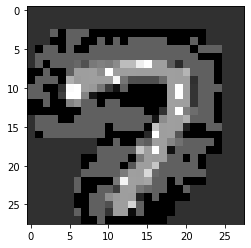

In [0]:
adv_images = FastGradientSignMethod(model, binary_test, binary_test_labels, epsilon=0.3)
TestAttack(model, adv_images, binary_test, binary_test_labels, targeted=False)

Test loss: 4.60
Successfully moved out of source class: 0.70
Test loss: 1.12
Successfully perturbed to target class: 0.70
Mean perturbation distance: 0.24


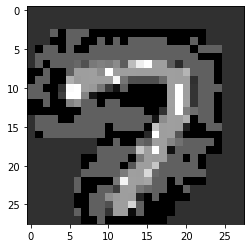

In [0]:
target = (np.argmax(binary_test_labels, axis=1) + np.random.randint(1, num_classes, size=(binary_test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
adv_images = TargetedGradientSignMethod(model, binary_test, target, epsilon=0.3)
TestAttack(model, adv_images, binary_test, binary_test_labels, target, targeted=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 10.73
Successfully moved out of source class: 0.98
Mean perturbation distance: 0.14


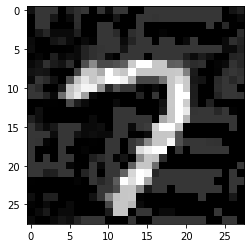

In [0]:
adv_images = BasicIterativeMethod(model, binary_test, binary_test_labels, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=False)
TestAttack(model, adv_images, binary_test, binary_test_labels, target, targeted=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 10.71
Successfully moved out of source class: 0.98
Test loss: 0.04
Successfully perturbed to target class: 0.98
Mean perturbation distance: 0.14


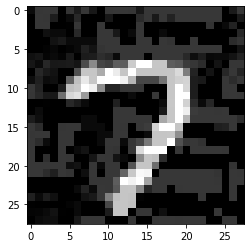

In [0]:
adv_images = BasicIterativeMethod(model, binary_test, target, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=True)
TestAttack(model, adv_images, binary_test, binary_test_labels, target, targeted=True)

## Simple binary classifier with Defensive Distilation

In [0]:
# train with distilation
Temperature = 30
teacher, student = trainAndTransferKnowladge(binary_train,binary_train_labels,binary_test,binary_test_labels, Temperature, num_classes)

train teacher:
Train on 12223 samples, validate on 2060 samples
Epoch 1/12
12223/12223 [==============================] - 9s 736us/sample - loss: 0.2179 - categorical_accuracy: 0.9584 - val_loss: 0.0810 - val_categorical_accuracy: 0.9752
Epoch 2/12
12223/12223 [==============================] - 7s 610us/sample - loss: 0.0548 - categorical_accuracy: 0.9803 - val_loss: 0.0719 - val_categorical_accuracy: 0.9752
Epoch 3/12
12223/12223 [==============================] - 8s 622us/sample - loss: 0.0466 - categorical_accuracy: 0.9848 - val_loss: 0.0584 - val_categorical_accuracy: 0.9820
Epoch 4/12
12223/12223 [==============================] - 8s 621us/sample - loss: 0.0408 - categorical_accuracy: 0.9863 - val_loss: 0.0551 - val_categorical_accuracy: 0.9825
Epoch 5/12
12223/12223 [==============================] - 8s 617us/sample - loss: 0.0378 - categorical_accuracy: 0.9880 - val_loss: 0.0496 - val_categorical_accuracy: 0.9845
Epoch 6/12
12223/12223 [==============================] - 8s 626us

In [0]:
student.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

Test loss: 9.38
Successfully moved out of source class: 0.04
Mean perturbation distance: 0.01


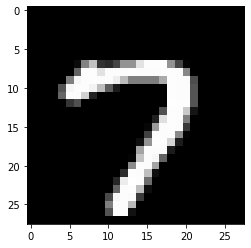

In [0]:
adv_images = FastGradientSignMethod(student, binary_test, binary_test_labels, epsilon=0.3)
TestAttack(student, adv_images, binary_test, binary_test_labels, targeted=False)

Test loss: 57.65
Successfully moved out of source class: 0.55
Test loss: 42.35
Successfully perturbed to target class: 0.55
Mean perturbation distance: 0.24


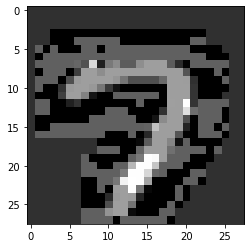

In [0]:
target = (np.argmax(binary_test_labels, axis=1) + np.random.randint(1, num_classes, size=(binary_test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
adv_images = TargetedGradientSignMethod(student, binary_test, target, epsilon=0.3)
TestAttack(student, adv_images, binary_test, binary_test_labels, target, targeted=True)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 13.31
Successfully moved out of source class: 0.04
Mean perturbation distance: 0.01


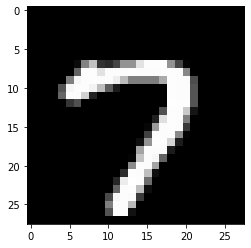

In [0]:
adv_images = BasicIterativeMethod(student, binary_test, binary_test_labels, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=False)
TestAttack(student, adv_images, binary_test, binary_test_labels, target, targeted=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Test loss: 76.71
Successfully moved out of source class: 0.70
Test loss: 27.86
Successfully perturbed to target class: 0.70
Mean perturbation distance: 0.13


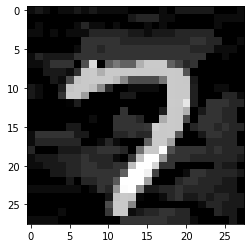

In [0]:
adv_images = BasicIterativeMethod(student, binary_test, target, iterations = 30, epsilon=4.0, iter_eps=0.05, targeted=True)
TestAttack(student, adv_images, binary_test, binary_test_labels, target, targeted=True)

## Visualization for Defensive Distillation

Logits & softmax outputs for regular model

In [0]:
Logits_out = tf.keras.models.Model(inputs=model.input,
                    outputs=model.layers[-2].output)


<function matplotlib.pyplot.show>

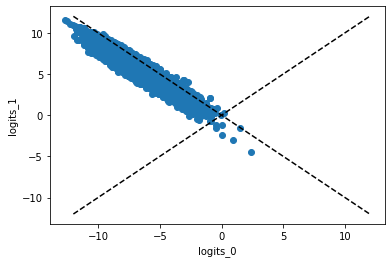

In [0]:
norm_logits = Logits_out.predict(class2_train)
norm_logit0 = norm_logits[:,0]
norm_logit1 = norm_logits[:,1]

plt.scatter(norm_logit0, norm_logit1)
plt.xlabel('logits_0')
plt.ylabel('logits_1')
plt.plot([-12, 12], [12, -12], linestyle='dashed', color='black')
plt.plot([-12, 12], [-12, 12], linestyle='dashed', color='black')
plt.show

<function matplotlib.pyplot.show>

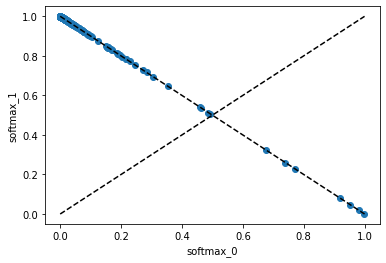

In [0]:
norm_softmax = model.predict(class2_train)
norm_soft0 = norm_softmax[:,0]
norm_soft1 = norm_softmax[:,1]

plt.scatter(norm_soft0, norm_soft1)
plt.xlabel('softmax_0')
plt.ylabel('softmax_1')
plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
plt.plot([0, 1], [1, 0], linestyle='dashed', color='black')
plt.show

In [0]:
Logits_out_student = tf.keras.models.Model(inputs=student.input,
                            outputs=student.layers[-2].output)

<function matplotlib.pyplot.show>

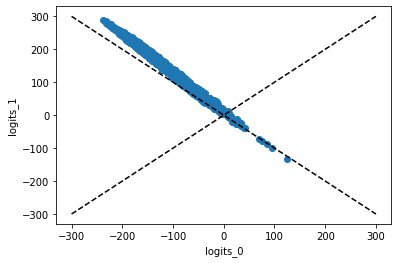

In [0]:
studnt_logits = Logits_out_student.predict(class2_train)
studnt_logit0 = studnt_logits[:,0]
studnt_logit1 = studnt_logits[:,1]

plt.scatter(studnt_logit0, studnt_logit1)
plt.xlabel('logits_0')
plt.ylabel('logits_1')
plt.plot([-300, 300], [300, -300], linestyle='dashed', color='black')
plt.plot([-300, 300], [-300, 300], linestyle='dashed', color='black')
plt.show

<function matplotlib.pyplot.show>

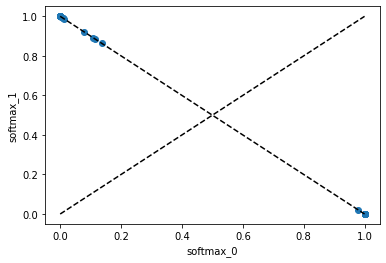

In [0]:
student_softmax = student.predict(class2_train)
student_softmax0 = student_softmax[:,0]
student_softmax1 = student_softmax[:,1]

plt.scatter(student_softmax0, student_softmax1)
plt.xlabel('softmax_0')
plt.ylabel('softmax_1')
plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
plt.plot([0, 1], [1, 0], linestyle='dashed', color='black')
plt.show